In [8]:
# This code is heavily inspired by this tutorial: https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch
import torch.nn as nn

from architecture import recursive

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(SEED)

In [9]:
df_train = pd.read_csv("data/lyrics.csv/lyrics.csv")

In [20]:
i=0
pop_lyrics = list()
while i < len(df_train.index):
    if df_train['genre'][i] == 'Pop' and type(df_train['lyrics'][i]) == str:
        pop_lyrics.append(df_train['lyrics'][i])
    i += 1

def joinStrings(text):
    return ' '.join(string for string in text)

pop_text = joinStrings(pop_lyrics[:100])
len(pop_text.split())

36987

In [21]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(pop_text).lower().split()

In [22]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['oh', 'baby'], 'doing'), (['baby', 'doing'], 'you'), (['doing', 'you'], 'know')]


In [23]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [24]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [25]:
def train(inp, target):
    if torch.backends.cudnn.enabled:
        hidden = decoder.init_hidden().cuda()
    else:
        hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        if torch.backends.cudnn.enabled:
            output, hidden = decoder(inp[c].cuda(), hidden)
            loss += criterion(output, target[c].cuda())
        else:
            output, hidden = decoder(inp[c], hidden)
            loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [26]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [27]:
n_epochs = 20
print_every = 1
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = recursive.RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if torch.backends.cudnn.enabled:
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 21s (1 5%) 7.9908]
 41s (2 10%) 7.5451]
 2s (3 15%) 6.8581]
 23s (4 20%) 6.2012]
 44s (5 25%) 5.8873]
 5s (6 30%) 5.5759]
 26s (7 35%) 5.3096]
 47s (8 40%) 5.0411]
 8s (9 45%) 4.7703]
 29s (10 50%) 4.5030]
 50s (11 55%) 4.2388]
 10s (12 60%) 3.9791]
 31s (13 65%) 3.7288]
 52s (14 70%) 3.4923]
 13s (15 75%) 3.2703]
 34s (16 80%) 3.0617]
 55s (17 85%) 2.8651]
 15s (18 90%) 2.6795]
 36s (19 95%) 2.5052]
 56s (20 100%) 2.3422]


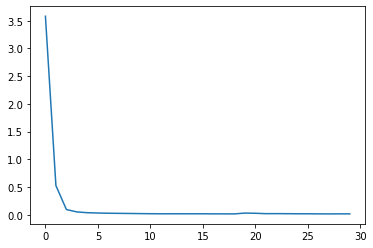

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [12]:
torch.save(decoder.state_dict(), "model/trigram_pop_10.pth")